In [1]:
#### SetUp

import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV, KFold
from sklearn.linear_model import Lasso, LogisticRegression, RidgeClassifier
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.svm import SVC, OneClassSVM
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.ensemble import GradientBoostingClassifier

import pywt
import numpy as np
import pandas as pd
import pywt
import seaborn as sns
import scaleogram as scg 
import matplotlib.pyplot as plt
import matplotlib.gridspec as GridSpec
from mat4py import loadmat
from scipy.fftpack import fft
import seaborn as sn

import matplotlib.pyplot as plt
from scipy.stats import mode
from statsmodels.tsa.stattools import acf, pacf

from collections import Counter
from scipy import stats
from itertools import repeat

import biosppy.signals.ecg as ecg

vColors = ["#049DD9", "#03A64A", "#F2AC29", "#F2CA80", "#F22929"]

In [16]:
# Import

X_train = pd.read_csv("X_train_processed.csv").drop(["index"], axis=1)
y_train = np.ravel(pd.read_csv("y_train.csv").drop("id",axis = 1).to_numpy())

In [17]:
X_train = X_train.replace(np.inf, np.nan)
X_train = X_train.replace(-np.inf, np.nan)

X_train.fillna(0, inplace=True)

X_train = X_train.dropna(axis=1, how="all")

In [4]:
# Adding the AC features to the processed data based on the raw data

X_train_raw = pd.read_csv("X_train.csv").drop(labels='id', axis=1).drop("x17978", axis = 1).to_numpy()

ACF = []
PACF = []

for i in range(0,X_train_raw.shape[0],1):
    if i % 500 == 0:
        print(i)
    ACF.append(acf(X_train_raw[i,:][~np.isnan(X_train_raw[i,:])], fft = True).tolist()[1:5])
    PACF.append(pacf(X_train_raw[i,:][~np.isnan(X_train_raw[i,:])]).tolist()[1:5])


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (17979) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000


In [19]:
ACF1 = pd.DataFrame(np.array(ACF))
PACF1 = pd.DataFrame(np.array(PACF))

X_train = pd.concat([X_train,ACF1,PACF1], axis = 1)

In [21]:
scaler = StandardScaler() 

X_train = pd.DataFrame(
    scaler.fit_transform(
    X_train),
    columns=X_train.columns)

In [20]:
# Parameter Tuning. Can be ignored rn.

param_test = {'max_depth': [15, 20, 25],
              'min_child_samples': [2,4,8],
              'subsample': [0.7,0.9],
              'colsample_bytree': [0.9, 0.7]}

gsearch5 = GridSearchCV(estimator=lgb.LGBMClassifier(boosting_type='gbdt',  
                                                    objective='multiclass',
                                                    num_iterations = 100,
                                                    learning_rate = 0.1,
                                                    num_threads = 4,
                                                    class_weight="balanced",
                                                    random_state = 42),
                        param_grid=param_test,
                        scoring="f1_micro",
                        n_jobs= -1, 
                        cv=5)

gsearch5.fit(X_train, y_train)

pd.DataFrame(gsearch5.cv_results_).sort_values("rank_test_score")
print(gsearch5.best_params_)
print(gsearch5.best_score_)

In [24]:
F1 = []
cv = KFold(n_splits=5)

# model_1 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=7, 
#                                     min_samples_split=60, min_samples_leaf=9, subsample=1,
#                                     max_features=50, random_state=42)

model_1 = lgb.LGBMClassifier(objective='multiclass',
                        n_estimators = 500,
                        learning_rate = 0.05,
                        random_state=42,
                        max_depth = 15,
                        min_child_samples = 8,
                        min_child_weight = 0,
                        subsample = 0.8,
                        colsample_bytree = 0.8,
                        class_weight = "balanced"
                        )

# model_3 = SVC(class_weight="balanced", random_state=42, C = 8.858667904100823, gamma = "auto")

for train_ix, test_ix in cv.split(X_train):

    X_cvtrain, X_cvtest = X_train.iloc[train_ix, :], X_train.iloc[test_ix, :]
    y_cvtrain, y_cvtest = y_train[train_ix], y_train[test_ix]

    model_1.fit(X_cvtrain, y_cvtrain)

    predtrain_1 = model_1.predict(X_cvtrain)
    pred_1 = model_1.predict(X_cvtest)

    # model_2.fit(X_cvtrain, y_cvtrain)

    # predtrain_2 = model_2.predict(X_cvtrain)
    # pred_2 = model_2.predict(X_cvtest)

    # model_3.fit(X_cvtrain, y_cvtrain)

    # predtrain_3 = model_3.predict(X_cvtrain)
    # pred_3 = model_3.predict(X_cvtest)

    predtrain = model_1.predict(X_cvtrain) #mode(np.array([predtrain_1,predtrain_2,predtrain_3]).T, axis=1)[0]
    pred = model_1.predict(X_cvtest) #mode(np.array([pred_1,pred_2,pred_3]).T, axis=1)[0]

    print("\nTrain F1:")
    print(np.round(f1_score(y_cvtrain, predtrain, average='micro'), 4))
    print("\nTest F1:")
    print(np.round(f1_score(y_cvtest, pred, average='micro'), 4))
    print("\n________________________")

    F1.append(np.round(f1_score(y_cvtest, pred, average= "micro"), 4))

print("\nAverage F1:", round(np.sum(F1)/5, 4))
print("Std:", round(np.std(F1), 4))


Train F1:
1.0

Test F1:
0.8359

________________________

Train F1:
1.0

Test F1:
0.834

________________________

Train F1:
1.0

Test F1:
0.8192

________________________

Train F1:
1.0

Test F1:
0.828

________________________

Train F1:
1.0

Test F1:
0.8328

________________________

Average F1: 0.83
Std: 0.006


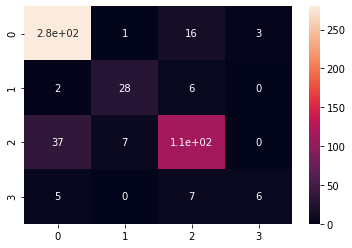

In [9]:
sn.heatmap(confusion_matrix(y_cvtest, pred), annot=True)

In [11]:
X_test = pd.read_csv("x_test_processed.csv").drop(["index"], axis=1)

X_test = X_test.replace(np.inf, np.nan)
X_test = X_test.replace(-np.inf, np.nan)

X_test.fillna(0, inplace=True)

X_test = X_test.dropna(axis=1, how="all")


In [ ]:
X_test_raw = pd.read_csv("X_test.csv").drop(labels='id', axis=1).drop("x17978", axis = 1).to_numpy()

ACF = []
PACF = []

for i in range(0,X_test_raw.shape[0],1):
    if i % 500 == 0:
        print(i)
    ACF.append(acf(X_test_raw[i,:][~np.isnan(X_test_raw[i,:])], fft = True).tolist()[1:5])
    PACF.append(pacf(X_test_raw[i,:][~np.isnan(X_test_raw[i,:])]).tolist()[1:5])


In [13]:
ACF2 = pd.DataFrame(np.array(ACF))
PACF2 = pd.DataFrame(np.array(PACF))

X_test = pd.concat([X_test,ACF2,PACF2], axis = 1)

In [14]:
X_test = pd.DataFrame(
    scaler.fit_transform(
    X_test),
    columns=X_test.columns)

In [22]:
model_1.fit(X_train, y_train)
#model_2.fit(X_train, y_train)
#model_3.fit(X_train, y_train)

#preds_1 = model_1.predict(X_test)
#preds_2 = model_1.predict(X_test)
#preds_3 = model_1.predict(X_test)

preds = model_1.predict(X_test) #mode(np.array([preds_1,preds_2,preds_3]).T, axis=1)[0].tolist()
#preds = [item for sublist in preds for item in sublist]

dfResults = pd.DataFrame({"id": list(range(0, X_test.shape[0], 1)), "y": preds})

dfResults.to_csv("Results.csv", sep=',', index=False)